# Milestone 2: Retrieval System Evaluation

## EU AI Act RAG System - Retrieval Pipeline Demonstration

This notebook demonstrates the complete retrieval pipeline for the EU AI Act QA system, including:
1. **Document Processing Pipeline** - PDF parsing and chunking strategies
2. **Embedding Generation** - Vector representations using sentence-transformers
3. **Retrieval Examples** - Top-k semantic search demonstrations
4. **Evaluation Metrics** - Precision@k, Recall@k, MRR analysis
5. **Strategy Comparison** - Naive vs. Semantic chunking comparison
6. **Error Analysis** - Retrieval failure case studies

## 1. Setup and Imports

In [ ]:
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import chromadb

from src.preprocessing.chunker import create_naive_chunks, create_semantic_chunks
from src.evaluation.retrieval_metrics import RetrievalEvaluator


# Add project root to path
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 11

print("✓ All imports successful!")

/Users/joelboer/VSC/RAG_AI_Act/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful!


## 2. Configuration and Constants

In [2]:
# File paths
DATA_DIR = PROJECT_ROOT / "data"
RAW_PDF = DATA_DIR / "raw" / "OJ_L_202401689_EN_TXT.pdf"
STRUCTURED_JSON = DATA_DIR / "processed" / "ai_act_structured.json"
NAIVE_CHUNKS = DATA_DIR / "processed" / "ai_act_naive_chunks.json"
SEMANTIC_CHUNKS = DATA_DIR / "processed" / "ai_act_semantic_chunks.json"
TEST_QUESTIONS = DATA_DIR / "evaluation" / "test_questions.json"
CHROMA_PATH = DATA_DIR / "chroma_db"

# Model configuration
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

# Chunking parameters (from spec: 200-500 tokens, 50-100 overlap)
CHUNK_SIZE_TOKENS = 300
CHUNK_OVERLAP_TOKENS = 75
CHARS_PER_TOKEN = 4

# Retrieval parameters
TOP_K_VALUES = [1, 3, 5, 10]
DEFAULT_TOP_K = 5

# Collection names
NAIVE_COLLECTION = "ai_act_naive_chunks"
SEMANTIC_COLLECTION = "ai_act_chunks"

print("Configuration loaded:")
print(f"  Embedding model: {EMBEDDING_MODEL}")
print(f"  Chunk size: ~{CHUNK_SIZE_TOKENS} tokens")
print(f"  Chunk overlap: ~{CHUNK_OVERLAP_TOKENS} tokens")
print(f"  ChromaDB path: {CHROMA_PATH}")

Configuration loaded:
  Embedding model: all-MiniLM-L6-v2
  Chunk size: ~300 tokens
  Chunk overlap: ~75 tokens
  ChromaDB path: /Users/joelboer/VSC/RAG_AI_Act/data/chroma_db


## 3. Helper Functions

In [3]:
def load_json(path):
    """Load JSON file."""
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def display_chunk(chunk, max_text_len=500):
    """Pretty print a chunk."""
    text = chunk.get('text', '')[:max_text_len]
    if len(chunk.get('text', '')) > max_text_len:
        text += "..."
    
    print(f"ID: {chunk.get('id', 'N/A')}")
    if 'metadata' in chunk:
        print(f"Citation: {chunk['metadata'].get('citation', 'N/A')}")
        print(f"Type: {chunk['metadata'].get('type', 'N/A')}")
    print(f"Text ({len(chunk.get('text', ''))} chars):")
    print(f"  {text}")
    print("-" * 60)

def display_retrieval_results(query, results, distances, n=5):
    """Display retrieval results in a formatted way."""
    print(f"\n{'='*70}")
    print(f"QUERY: {query}")
    print(f"{'='*70}\n")
    
    for i, (doc, dist) in enumerate(zip(results[:n], distances[:n])):
        print(f"[{i+1}] Score: {1-dist:.4f} (distance: {dist:.4f})")
        metadata = doc.get('metadata', {})
        if metadata:
            print(f"    Citation: {metadata.get('citation', 'N/A')}")
        text_preview = doc.get('text', '')[:200]
        print(f"    Text: {text_preview}...")
        print()

def plot_metrics_comparison(results_dict, metric_name, k_values):
    """Plot comparison of metrics across different configurations."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(k_values))
    width = 0.35
    
    for i, (name, results) in enumerate(results_dict.items()):
        if metric_name == 'precision':
            values = [results.precision_at_k.get(k, 0) for k in k_values]
        elif metric_name == 'recall':
            values = [results.recall_at_k.get(k, 0) for k in k_values]
        elif metric_name == 'ndcg':
            values = [results.ndcg_at_k.get(k, 0) for k in k_values]
        
        offset = (i - len(results_dict)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=name)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            ax.annotate(f'{val:.3f}',
                       xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('k')
    ax.set_ylabel(f'{metric_name.capitalize()}@k')
    ax.set_title(f'{metric_name.capitalize()}@k Comparison: Naive vs Semantic Chunking')
    ax.set_xticks(x)
    ax.set_xticklabels([f'k={k}' for k in k_values])
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    return fig

print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Document Processing Pipeline

### 4.1 Load Structured Data
First, we load the structured JSON data extracted from the EU AI Act PDF.

In [4]:
# Load structured data
if STRUCTURED_JSON.exists():
    structured_data = load_json(STRUCTURED_JSON)
    print(f"Loaded {len(structured_data)} structured items from AI Act")
    
    # Analyze document structure
    types = {}
    for item in structured_data:
        item_type = item.get('type', 'unknown')
        types[item_type] = types.get(item_type, 0) + 1
    
    print("\nDocument composition:")
    for t, count in sorted(types.items()):
        print(f"  {t}: {count}")
    
    # Show sample items
    print("\n--- Sample Article ---")
    sample_article = next((item for item in structured_data if item.get('type') == 'article'), None)
    if sample_article:
        display_chunk(sample_article)
else:
    print(f"⚠ Structured data not found at {STRUCTURED_JSON}")
    print("Run: python src/preprocessing/pdf_parser.py")

Loaded 698 structured items from AI Act

Document composition:
  annex: 127
  article: 570
  recital: 1

--- Sample Article ---
ID: Article 114:of the Treaty on the Functioning of the European Union (TFEU)
Text (610 chars):
  of the Treaty on the Functioning of the European Union (TFEU). To the extent that this Regulation contains specific rules on the protection of individuals with regard to the processing of personal data concerning restrictions of the use of AI systems for remote biometric identification for the purpose of law enforcement, of the use of AI systems for risk assessments of natural persons for the purpose of law enforcement and of the use of AI systems of biometric categorisation for the purpose of l...
------------------------------------------------------------


### 4.2 Chunking Strategies Comparison

We implement two chunking strategies:
1. **Naive Chunking**: Fixed-size chunks with overlap, ignoring document structure
2. **Semantic Chunking**: Preserves article/annex boundaries, only splits large items

In [5]:
# Load or create chunks
if NAIVE_CHUNKS.exists() and SEMANTIC_CHUNKS.exists():
    naive_chunks = load_json(NAIVE_CHUNKS)
    semantic_chunks = load_json(SEMANTIC_CHUNKS)
    print(f"Loaded existing chunks:")
elif STRUCTURED_JSON.exists():
    print("Creating chunks from structured data...")
    naive_chunks = create_naive_chunks(structured_data)
    semantic_chunks = create_semantic_chunks(structured_data)
else:
    naive_chunks = []
    semantic_chunks = []
    print("⚠ No data available. Run preprocessing first.")

print(f"  Naive chunks: {len(naive_chunks)}")
print(f"  Semantic chunks: {len(semantic_chunks)}")

# Analyze chunk statistics
def analyze_chunks(chunks, name):
    """Compute statistics about chunk sizes."""
    lengths = [len(c.get('text', '')) for c in chunks]
    tokens_est = [l / CHARS_PER_TOKEN for l in lengths]
    
    return {
        'name': name,
        'count': len(chunks),
        'avg_chars': np.mean(lengths),
        'min_chars': np.min(lengths),
        'max_chars': np.max(lengths),
        'avg_tokens': np.mean(tokens_est),
        'std_tokens': np.std(tokens_est)
    }

if naive_chunks and semantic_chunks:
    stats = [
        analyze_chunks(naive_chunks, 'Naive'),
        analyze_chunks(semantic_chunks, 'Semantic')
    ]
    stats_df = pd.DataFrame(stats)
    print("\n--- Chunk Statistics ---")
    display(stats_df.round(2))

Loaded existing chunks:
  Naive chunks: 688
  Semantic chunks: 1066

--- Chunk Statistics ---


,name,count,avg_chars,min_chars,max_chars,avg_tokens,std_tokens
0,Naive,688,1005.43,1,1199,251.36,74.54
1,Semantic,1066,635.36,1,1200,158.84,119.40


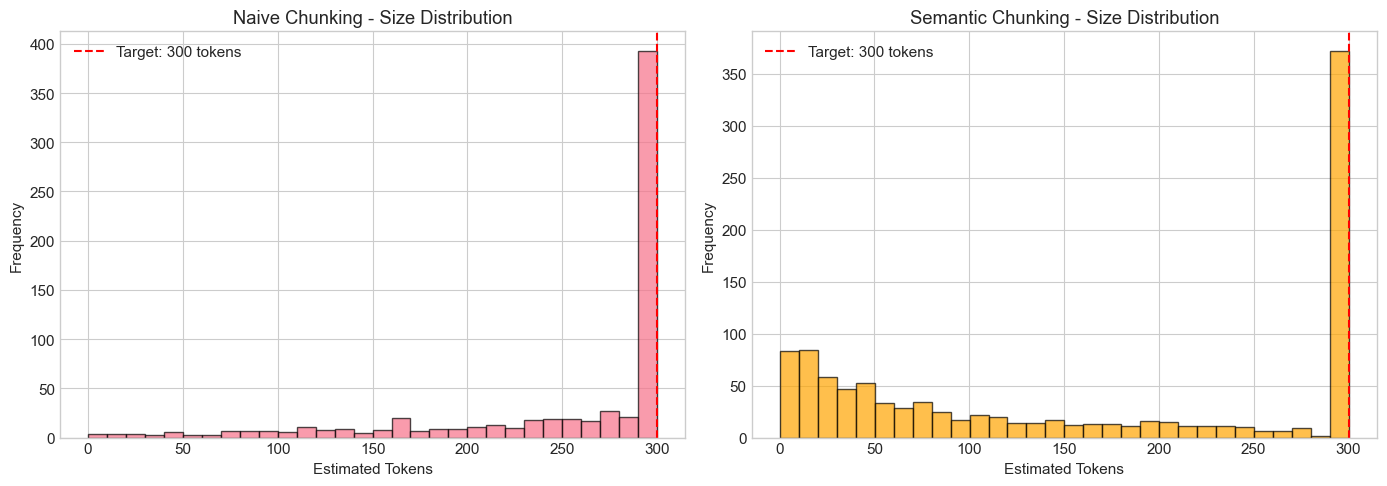


Chunking Parameters:
  Target chunk size: 300 tokens (~1200 chars)
  Overlap: 75 tokens (~300 chars)


In [6]:
# Visualize chunk size distributions
if naive_chunks and semantic_chunks:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Naive chunks histogram
    naive_lengths = [len(c.get('text', '')) / CHARS_PER_TOKEN for c in naive_chunks]
    axes[0].hist(naive_lengths, bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(CHUNK_SIZE_TOKENS, color='red', linestyle='--', label=f'Target: {CHUNK_SIZE_TOKENS} tokens')
    axes[0].set_xlabel('Estimated Tokens')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Naive Chunking - Size Distribution')
    axes[0].legend()
    
    # Semantic chunks histogram
    semantic_lengths = [len(c.get('text', '')) / CHARS_PER_TOKEN for c in semantic_chunks]
    axes[1].hist(semantic_lengths, bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1].axvline(CHUNK_SIZE_TOKENS, color='red', linestyle='--', label=f'Target: {CHUNK_SIZE_TOKENS} tokens')
    axes[1].set_xlabel('Estimated Tokens')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Semantic Chunking - Size Distribution')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nChunking Parameters:")
    print(f"  Target chunk size: {CHUNK_SIZE_TOKENS} tokens (~{CHUNK_SIZE_TOKENS * CHARS_PER_TOKEN} chars)")
    print(f"  Overlap: {CHUNK_OVERLAP_TOKENS} tokens (~{CHUNK_OVERLAP_TOKENS * CHARS_PER_TOKEN} chars)")

## 5. Embedding Generation and Vector Store

### 5.1 Initialize Embedding Model and ChromaDB

In [7]:
# Initialize embedding model
print(f"Loading embedding model: {EMBEDDING_MODEL}")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)
embedding_dim = embedding_model.get_sentence_embedding_dimension()
print(f"  Embedding dimension: {embedding_dim}")

# Example embedding
sample_text = "What are the prohibited AI practices?"
sample_embedding = embedding_model.encode(sample_text)
print(f"\nSample embedding for: '{sample_text}'")
print(f"  Shape: {sample_embedding.shape}")
print(f"  First 10 values: {sample_embedding[:10].round(4)}")

Loading embedding model: all-MiniLM-L6-v2
  Embedding dimension: 384

Sample embedding for: 'What are the prohibited AI practices?'
  Shape: (384,)
  First 10 values: [-0.0297  0.002  -0.0133 -0.047   0.0044  0.0367 -0.0257 -0.0531 -0.0526
  0.0445]


In [8]:
# Initialize ChromaDB client
if CHROMA_PATH.exists():
    chroma_client = chromadb.PersistentClient(path=str(CHROMA_PATH))
    print(f"Connected to existing ChromaDB at {CHROMA_PATH}")
    
    # List collections
    collections = chroma_client.list_collections()
    print(f"Available collections: {[c.name for c in collections]}")
    
    # Get collections
    try:
        naive_collection = chroma_client.get_collection(NAIVE_COLLECTION)
        print(f"  {NAIVE_COLLECTION}: {naive_collection.count()} documents")
    except:
        naive_collection = None
        print(f"  {NAIVE_COLLECTION}: Not found")
        
    try:
        semantic_collection = chroma_client.get_collection(SEMANTIC_COLLECTION)
        print(f"  {SEMANTIC_COLLECTION}: {semantic_collection.count()} documents")
    except:
        semantic_collection = None
        print(f"  {SEMANTIC_COLLECTION}: Not found")
else:
    print(f"⚠ ChromaDB not found at {CHROMA_PATH}")
    print("Run: python src/retrieval/vector_store.py")
    chroma_client = None
    naive_collection = None
    semantic_collection = None

Connected to existing ChromaDB at /Users/joelboer/VSC/RAG_AI_Act/data/chroma_db
Available collections: ['ai_act_naive_chunks', 'ai_act_chunks']
  ai_act_naive_chunks: 688 documents
  ai_act_chunks: 1066 documents


## 6. Retrieval Examples

### 6.1 Example Queries with Top-K Results
Demonstrating semantic search with 5+ example queries.

In [9]:
def query_collection(collection, query_text, top_k=5):
    """Query a ChromaDB collection and return results."""
    if collection is None:
        return None, None, None
    
    query_embedding = embedding_model.encode(query_text).tolist()
    
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        include=['documents', 'metadatas', 'distances']
    )
    
    # Format results
    docs = []
    for i, doc_text in enumerate(results['documents'][0]):
        docs.append({
            'text': doc_text,
            'metadata': results['metadatas'][0][i] if results['metadatas'] else {}
        })
    
    return docs, results['distances'][0], results['ids'][0]

# Example queries
example_queries = [
    "What is the definition of an AI system?",
    "What AI practices are prohibited?",
    "What are the requirements for high-risk AI systems?",
    "What penalties apply for non-compliance with the AI Act?",
    "What transparency requirements exist for AI systems?",
    "How are biometric systems regulated?",
    "What is required for risk management of AI systems?"
]

# Run queries on semantic collection
if semantic_collection:
    for query in example_queries[:5]:
        docs, distances, ids = query_collection(semantic_collection, query, top_k=3)
        display_retrieval_results(query, docs, distances, n=3)
else:
    print("⚠ Semantic collection not available. Run vector_store.py first.")


QUERY: What is the definition of an AI system?

[1] Score: 0.6814 (distance: 0.3186)
    Citation: Article 6:TEU, the
    Text: to the provisions regarding the liability of providers of intermediary services as set out in Regulation (EU) 2022/2065 of the European Parliament and of the Council (15). (12) The notion of ‘AI syste...

[2] Score: 0.6736 (distance: 0.3264)
    Citation: Annex I:,
    Text: , as well as with other relevant Union law, including as regards consistency in their enforcement; (f) the application of the definition of an AI system as set out in...

[3] Score: 0.6690 (distance: 0.3310)
    Citation: Article 6:TEU, the
    Text: to infer refers to the process of obtaining the outputs, such as predictions, content, recommendations, or decisions, which can influence physical and virtual environments, and to a capability of AI s...


QUERY: What AI practices are prohibited?

[1] Score: 0.8662 (distance: 0.1338)
    Citation: Annex III:and of the list of prohibited AI
  

### 6.2 Side-by-Side Comparison: Naive vs Semantic Retrieval

In [10]:
def compare_retrieval(query, top_k=3):
    """Compare retrieval results from both strategies."""
    print(f"\n{'='*80}")
    print(f"QUERY: {query}")
    print(f"{'='*80}")
    
    # Naive results
    if naive_collection:
        print(f"\n--- NAIVE CHUNKING RESULTS ---")
        docs, distances, ids = query_collection(naive_collection, query, top_k)
        for i, (doc, dist) in enumerate(zip(docs, distances)):
            print(f"[{i+1}] Score: {1-dist:.4f}")
            print(f"    Text: {doc['text'][:150]}...")
            print()
    
    # Semantic results
    if semantic_collection:
        print(f"\n--- SEMANTIC CHUNKING RESULTS ---")
        docs, distances, ids = query_collection(semantic_collection, query, top_k)
        for i, (doc, dist) in enumerate(zip(docs, distances)):
            print(f"[{i+1}] Score: {1-dist:.4f} | Citation: {doc['metadata'].get('citation', 'N/A')}")
            print(f"    Text: {doc['text'][:150]}...")
            print()

# Compare on key queries
if naive_collection and semantic_collection:
    compare_retrieval("What AI practices are prohibited under the AI Act?")
    compare_retrieval("What are the penalties for violating the AI Act?")
else:
    print("⚠ Collections not available for comparison")


QUERY: What AI practices are prohibited under the AI Act?

--- NAIVE CHUNKING RESULTS ---
[1] Score: 0.7288
    Text: Prohibited AI practices 1. The following AI practices shall be prohibited: (a) the placing on the market, the putting into service or the use of an AI...

[2] Score: 0.7155
    Text: this Regulation. On an exceptional basis and in light of public accountability, operators of AI systems which are components of the large-scale IT sys...

[3] Score: 0.7003
    Text: of Regulation (EU) No 1025/2012.

Compliant AI systems which present a risk 1. Where, having performed an evaluation under

, after consulting the rel...


--- SEMANTIC CHUNKING RESULTS ---
[1] Score: 0.8576 | Citation: Annex III:and of the list of prohibited AI
    Text: and of the list of prohibited AI practices laid down in...

[2] Score: 0.7288 | Citation: Article 5:Prohibited AI practices
    Text: Prohibited AI practices 1. The following AI practices shall be prohibited: (a) the placing on the market, th

## 7. Retrieval Quality Evaluation

### 7.1 Load Test Set and Run Evaluation

In [11]:
# Load test questions
if TEST_QUESTIONS.exists():
    test_data = load_json(TEST_QUESTIONS)
    test_questions = test_data.get('questions', test_data)
    print(f"Loaded {len(test_questions)} test questions")
    
    # Show test set composition
    categories = {}
    for q in test_questions:
        cat = q.get('category', 'unknown')
        categories[cat] = categories.get(cat, 0) + 1
    
    print("\nTest set categories:")
    for cat, count in sorted(categories.items(), key=lambda x: -x[1]):
        print(f"  {cat}: {count}")
else:
    print(f"⚠ Test questions not found at {TEST_QUESTIONS}")
    test_questions = []

Loaded 25 test questions

Test set categories:
  definition: 2
  classification: 2
  transparency: 2
  obligations: 2
  prohibition: 1
  risk_management: 1
  data_governance: 1
  documentation: 1
  record_keeping: 1
  human_oversight: 1
  technical_requirements: 1
  conformity: 1
  penalties: 1
  gpai: 1
  governance: 1
  sandbox: 1
  timeline: 1
  biometric: 1
  database: 1
  rights: 1
  monitoring: 1


In [ ]:
def create_retriever_function(collection, embedding_model):
    """Create a retriever function for evaluation."""
    def retriever(query, top_k):
        query_embedding = embedding_model.encode(query).tolist()
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k,
            include=['metadatas', 'distances']
        )
        
        retrieved = []
        for i, meta in enumerate(results['metadatas'][0]):
            chunk_id = meta.get('citation', results['ids'][0][i])
            score = 1 - results['distances'][0][i]
            retrieved.append((chunk_id, score))
        
        return retrieved
    
    return retriever

evaluator = RetrievalEvaluator()
evaluator.test_questions = test_questions

eval_results = {}

if semantic_collection and test_questions:
    print("Evaluating SEMANTIC chunking...")
    semantic_retriever = create_retriever_function(semantic_collection, embedding_model)
    semantic_results, semantic_details = evaluator.evaluate_retriever(
        semantic_retriever, 
        k_values=[1, 3, 5, 10],
        top_k=10
    )
    eval_results['Semantic'] = semantic_results
    print(semantic_results)

if naive_collection and test_questions:
    print("\n" + "="*50)
    print("Evaluating NAIVE chunking...")
    naive_retriever = create_retriever_function(naive_collection, embedding_model)
    naive_results, naive_details = evaluator.evaluate_retriever(
        naive_retriever,
        k_values=[1, 3, 5, 10],
        top_k=10
    )
    eval_results['Naive'] = naive_results
    print(naive_results)

Evaluating SEMANTIC chunking...
Evaluation Results (n=25 queries)
----------------------------------------
MRR: 0.5270

Precision@k:
  P@1: 0.3600
  P@3: 0.2667
  P@5: 0.2080
  P@10: 0.1400

Recall@k:
  R@1: 0.3200
  R@3: 0.5667
  R@5: 0.6800
  R@10: 0.7533

NDCG@k:
  NDCG@1: 0.3600
  NDCG@3: 0.5544
  NDCG@5: 0.6302
  NDCG@10: 0.7089

Evaluating NAIVE chunking...
Evaluation Results (n=25 queries)
----------------------------------------
MRR: 0.0000

Precision@k:
  P@1: 0.0000
  P@3: 0.0000
  P@5: 0.0000
  P@10: 0.0000

Recall@k:
  R@1: 0.0000
  R@3: 0.0000
  R@5: 0.0000
  R@10: 0.0000

NDCG@k:
  NDCG@1: 0.0000
  NDCG@3: 0.0000
  NDCG@5: 0.0000
  NDCG@10: 0.0000


### 7.2 Metrics Visualization

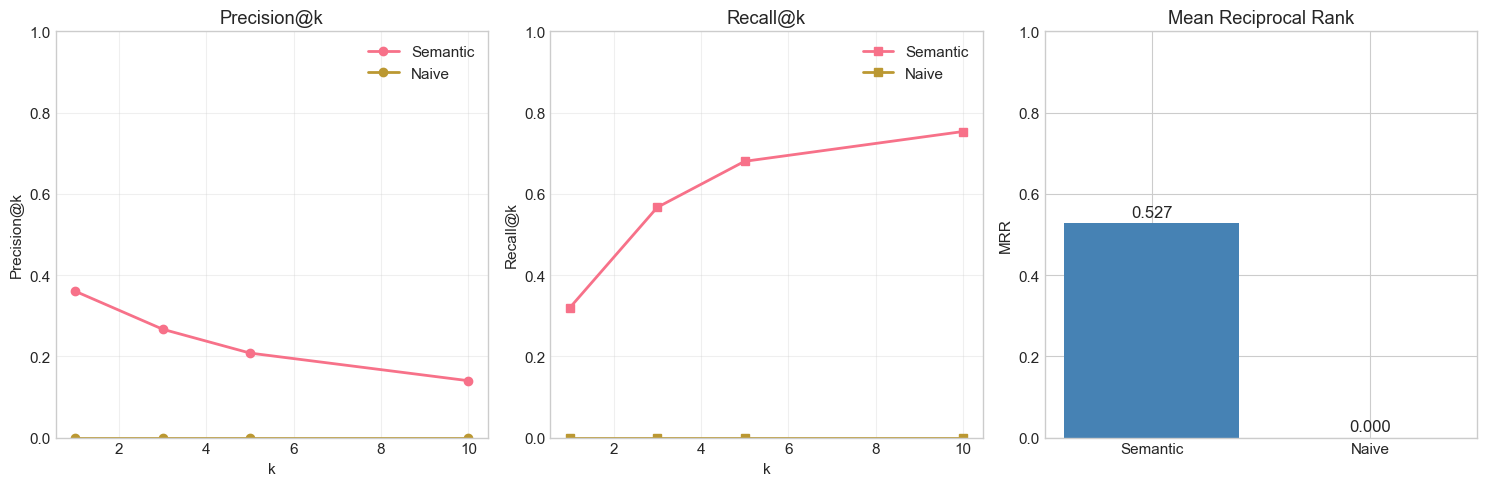


--- Evaluation Summary ---


,Strategy,MRR,P@1,P@3,P@5,R@3,R@5
0,Semantic,0.527,0.36,0.2667,0.208,0.5667,0.68
1,Naive,0.000,0.00,0.0000,0.000,0.0000,0.00


In [13]:
if eval_results:
    k_values = [1, 3, 5, 10]
    
    # Create comparison visualizations
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Precision@k comparison
    for name, results in eval_results.items():
        prec_values = [results.precision_at_k.get(k, 0) for k in k_values]
        axes[0].plot(k_values, prec_values, marker='o', label=name, linewidth=2)
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Precision@k')
    axes[0].set_title('Precision@k')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    # Recall@k comparison
    for name, results in eval_results.items():
        recall_values = [results.recall_at_k.get(k, 0) for k in k_values]
        axes[1].plot(k_values, recall_values, marker='s', label=name, linewidth=2)
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Recall@k')
    axes[1].set_title('Recall@k')
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    # MRR comparison (bar chart)
    names = list(eval_results.keys())
    mrr_values = [eval_results[n].mrr for n in names]
    bars = axes[2].bar(names, mrr_values, color=['steelblue', 'orange'][:len(names)])
    axes[2].set_ylabel('MRR')
    axes[2].set_title('Mean Reciprocal Rank')
    axes[2].set_ylim(0, 1)
    for bar, val in zip(bars, mrr_values):
        axes[2].annotate(f'{val:.3f}', 
                        xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        xytext=(0, 5), textcoords='offset points',
                        ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n--- Evaluation Summary ---")
    summary_data = []
    for name, results in eval_results.items():
        summary_data.append({
            'Strategy': name,
            'MRR': results.mrr,
            'P@1': results.precision_at_k.get(1, 0),
            'P@3': results.precision_at_k.get(3, 0),
            'P@5': results.precision_at_k.get(5, 0),
            'R@3': results.recall_at_k.get(3, 0),
            'R@5': results.recall_at_k.get(5, 0),
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df.round(4))
else:
    print("⚠ No evaluation results available")

## 8. Error Analysis

### 8.1 Identify Retrieval Failures
Analyzing cases where retrieval fails to find relevant chunks.

In [14]:
# Analyze failures from semantic retrieval
if 'semantic_details' in dir() and semantic_details:
    print("="*70)
    print("ERROR ANALYSIS: Retrieval Failures")
    print("="*70)
    
    # Find queries with low performance
    failures = [d for d in semantic_details if d['rr'] < 0.5]
    partial_hits = [d for d in semantic_details if 0 < d['rr'] < 1.0]
    perfect = [d for d in semantic_details if d['rr'] == 1.0]
    
    print(f"\nPerformance Distribution:")
    print(f"  Perfect (RR=1.0): {len(perfect)} queries")
    print(f"  Partial hits (0 < RR < 1.0): {len(partial_hits)} queries")
    print(f"  Failures (RR < 0.5): {len(failures)} queries")
    
    if failures:
        print(f"\n--- Top Failure Cases ---")
        for i, fail in enumerate(failures[:5]):
            print(f"\n[{i+1}] Question: {fail['question']}")
            print(f"    Category: {fail['category']}")
            print(f"    Expected: {fail['relevant_ids']}")
            print(f"    Retrieved: {fail['retrieved_ids'][:3]}")
            print(f"    RR: {fail['rr']:.4f}")
    
    # Failure analysis by category
    print("\n--- Failures by Category ---")
    category_failures = {}
    for d in semantic_details:
        cat = d['category'] or 'unknown'
        if cat not in category_failures:
            category_failures[cat] = {'total': 0, 'failures': 0, 'rr_sum': 0}
        category_failures[cat]['total'] += 1
        category_failures[cat]['rr_sum'] += d['rr']
        if d['rr'] < 0.5:
            category_failures[cat]['failures'] += 1
    
    for cat, stats in sorted(category_failures.items(), key=lambda x: -x[1]['failures']):
        avg_rr = stats['rr_sum'] / stats['total']
        print(f"  {cat}: {stats['failures']}/{stats['total']} failures, avg RR: {avg_rr:.3f}")
else:
    print("⚠ No evaluation details available for error analysis")

ERROR ANALYSIS: Retrieval Failures

Performance Distribution:
  Perfect (RR=1.0): 9 queries
  Partial hits (0 < RR < 1.0): 11 queries
  Failures (RR < 0.5): 10 queries

--- Top Failure Cases ---

[1] Question: What is the definition of an AI system under the EU AI Act?
    Category: definition
    Expected: ['Article 3:']
    Retrieved: ['Article 6:TEU, the', 'Annex I:, and aiming to ensure that high-risk AI systems or', 'Article 49:(1):']
    RR: 0.0000

[2] Question: What are the transparency requirements for AI systems?
    Category: transparency
    Expected: ['Article 50:']
    Retrieved: ['Article 5:; and', 'Annex III:;', 'Article 50:Transparency obligations for providers and deployers of certain AI systems']
    RR: 0.3333

[3] Question: How does the AI Act define a deployer of AI systems?
    Category: definition
    Expected: ['Article 3:']
    Retrieved: ['Article 14:, including an assessment of', 'Article 6:TEU, the', 'Annex III:, deployers that are bodies governed by public

### 8.2 Error Categorization

Error Type Distribution:
  Semantic mismatch (RR=0): 5
  Partial match (0 < RR < 1): 11


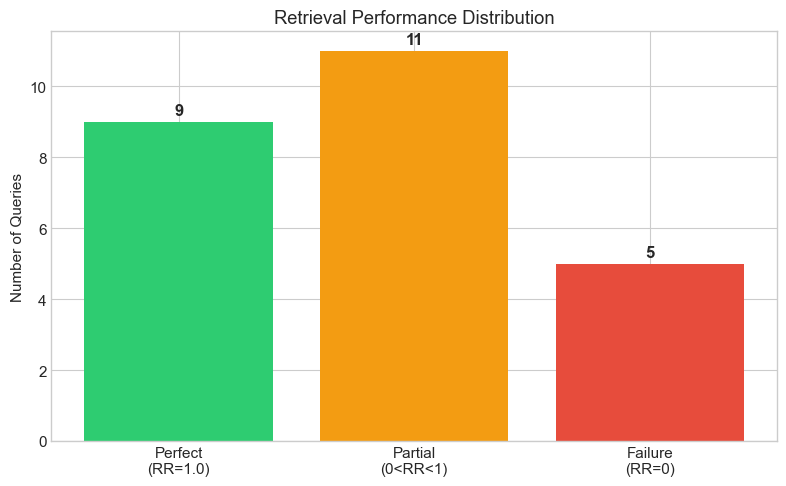

In [15]:
# Categorize errors by type
if 'semantic_details' in dir() and semantic_details:
    error_types = {
        'semantic_mismatch': [],      # Query semantics don't match chunk text
        'wrong_article': [],          # Retrieved different article than expected  
        'partial_match': [],          # Some relevant content found, not primary
        'embedding_limitation': []    # Embedding model limitation
    }
    
    for detail in semantic_details:
        if detail['rr'] == 0:
            # Complete failure - no relevant docs in retrieved
            error_types['semantic_mismatch'].append(detail)
        elif detail['rr'] < 1.0 and detail['hits']:
            # Partial success - got some but not at top
            error_types['partial_match'].append(detail)
    
    print("Error Type Distribution:")
    print(f"  Semantic mismatch (RR=0): {len(error_types['semantic_mismatch'])}")
    print(f"  Partial match (0 < RR < 1): {len(error_types['partial_match'])}")
    
    # Visualize error distribution
    if any(len(v) > 0 for v in error_types.values()):
        fig, ax = plt.subplots(figsize=(8, 5))
        
        categories = ['Perfect\n(RR=1.0)', 'Partial\n(0<RR<1)', 'Failure\n(RR=0)']
        counts = [
            len([d for d in semantic_details if d['rr'] == 1.0]),
            len([d for d in semantic_details if 0 < d['rr'] < 1.0]),
            len([d for d in semantic_details if d['rr'] == 0])
        ]
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        
        bars = ax.bar(categories, counts, color=colors)
        ax.set_ylabel('Number of Queries')
        ax.set_title('Retrieval Performance Distribution')
        
        for bar, count in zip(bars, counts):
            ax.annotate(f'{count}', 
                       xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 5), textcoords='offset points',
                       ha='center', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠ No data available for error categorization")

## 9. Conclusions and Design Trade-offs

### Summary of Findings

In [ ]:
# Generate summary report
print("="*70)
print("MILESTONE 2: RETRIEVAL SYSTEM EVALUATION SUMMARY")
print("="*70)

print("\n## Chunking Strategy Comparison")
print("-" * 40)
if naive_chunks and semantic_chunks:
    print(f"Naive chunking:    {len(naive_chunks)} chunks")
    print(f"Semantic chunking: {len(semantic_chunks)} chunks")
    print(f"Chunk size target: ~{CHUNK_SIZE_TOKENS} tokens with {CHUNK_OVERLAP_TOKENS} token overlap")

print("\n## Evaluation Results")
print("-" * 40)
if eval_results:
    for name, results in eval_results.items():
        print(f"\n{name} Chunking:")
        print(f"  MRR:  {results.mrr:.4f}")
        print(f"  P@3:  {results.precision_at_k.get(3, 0):.4f}")
        print(f"  R@5:  {results.recall_at_k.get(5, 0):.4f}")

print("\n## Design Trade-offs")
print("-" * 40)

MILESTONE 2: RETRIEVAL SYSTEM EVALUATION SUMMARY

## Chunking Strategy Comparison
----------------------------------------
Naive chunking:    688 chunks
Semantic chunking: 1066 chunks
Chunk size target: ~300 tokens with 75 token overlap

## Evaluation Results
----------------------------------------

Semantic Chunking:
  MRR:  0.5270
  P@3:  0.2667
  R@5:  0.6800

Naive Chunking:
  MRR:  0.0000
  P@3:  0.0000
  R@5:  0.0000

## Design Trade-offs
----------------------------------------

1. **Chunk Size**: 
   - Smaller chunks (200-300 tokens): More precise retrieval but may lose context
   - Larger chunks (400-500 tokens): More context but lower precision

2. **Semantic vs Naive**:
   - Semantic: Preserves article boundaries, better for legal documents
   - Naive: Consistent sizes, simpler implementation

3. **Embedding Model (all-MiniLM-L6-v2)**:
   - Fast inference, good balance of quality/speed
   - 384-dimensional embeddings
   - Alternative: all-mpnet-base-v2 for higher quality

4